# LSTM pipeline

In [13]:
import io
import itertools
import warnings
from typing import Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import torch
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

warnings.filterwarnings("ignore")

In [14]:
def get_train_test_sets(csv_path: str = "Datasets/DLL/ECDC/DLL_COVID_TRAIN.csv",forcast_days: int = 7) -> Tuple[pd.DataFrame, pd.DataFrame]:
    dataset = pd.read_csv(csv_path, parse_dates=["dateRep"])
    dataset = dataset.sort_values("dateRep")

    split_date = dataset["dateRep"].max() - np.timedelta64(forcast_days, "D")
    train_df = dataset.loc[dataset["dateRep"] < split_date]
    test_df = dataset.loc[dataset["dateRep"] >= split_date]
    return train_df, test_df


train_df, test_df = get_train_test_sets()
train_df.describe()

,cases,deaths,popData2018,GDP (current US$),GDP per capita (current US$),Access to electricity (% of population),Current health expenditure per capita (current US$),Current health expenditure (% of GDP),"Hospital beds (per 1,000 people)"
count,9828.000000,9828.000000,9.808000e+03,9.584000e+03,9584.000000,9637.000000,9140.000000,9140.000000,9368.000000
mean,159.050773,9.669516,6.308305e+07,8.348480e+11,24992.151043,92.819156,1776.065330,6.856349,3.465712
std,1232.001024,79.203402,1.991562e+08,2.595706e+12,30269.664182,18.127024,2281.596294,2.770746,2.852730
min,0.000000,0.000000,1.000000e+03,4.222968e+08,271.752044,9.300000,19.431646,1.181210,0.100000
25%,0.000000,0.000000,3.731000e+06,2.454247e+10,4114.715061,99.490387,195.935745,4.748105,1.500000
50%,0.000000,0.000000,1.062570e+07,1.406454e+11,11373.233003,100.000000,587.646301,6.541954,2.800000
75%,15.000000,0.000000,4.222843e+07,4.540128e+11,41715.029284,100.000000,2840.130615,8.873130,4.600000
max,34272.000000,2004.000000,1.392730e+09,2.054434e+13,185741.279992,100.000000,10246.138672,17.061269,18.680000


In [15]:
train_df.isna().sum(axis=0)

countryterritoryCode                                     0
dateRep                                                  0
cases                                                    0
deaths                                                   0
countriesAndTerritories                                  0
popData2018                                             20
GDP (current US$)                                      244
GDP per capita (current US$)                           244
Access to electricity (% of population)                191
Current health expenditure per capita (current US$)    688
Current health expenditure (% of GDP)                  688
Hospital beds (per 1,000 people)                       460
dtype: int64

In [16]:
def fill_na(
    train: pd.DataFrame, test: pd.DataFrame
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train = train.fillna(0)
    test = test.fillna(0)
    return train, test


train_df, test_df = fill_na(train_df, test_df)
display(train_df.isna().sum(axis=0))

countryterritoryCode                                   0
dateRep                                                0
cases                                                  0
deaths                                                 0
countriesAndTerritories                                0
popData2018                                            0
GDP (current US$)                                      0
GDP per capita (current US$)                           0
Access to electricity (% of population)                0
Current health expenditure per capita (current US$)    0
Current health expenditure (% of GDP)                  0
Hospital beds (per 1,000 people)                       0
dtype: int64

In [17]:
country = "Italy"

train_one_country = train_df[train_df["countriesAndTerritories"] == country]
test_one_country = test_df[test_df["countriesAndTerritories"] == country]


def add_last_cases_deaths(df: pd.DataFrame) -> pd.DataFrame:
    df["last_cases"] = df["cases"].shift(1)
    df["last_cases"] = df["last_cases"].fillna(0)
    df["last_deaths"] = df["deaths"].shift(1)
    df["last_deaths"] = df["last_deaths"].fillna(0)
    return df


train_one_country = add_last_cases_deaths(train_one_country)

In [8]:
class train_dataset(Dataset):
    def __init__(self, df: pd.DataFrame, length: int = 7):
        self.df = df.copy().drop(
            columns=["countryterritoryCode", "countriesAndTerritories"]
        )
        self.label_columns = ["cases", "deaths"]
        self.length = length

    def __len__(self):
        return len(self.df) - self.length + 1

    def __getitem__(self, idx):
        sample = self.df.iloc[idx : idx + self.length]

        cases = torch.tensor(sample.pop("cases").to_numpy()).float()
        deaths = torch.tensor(sample.pop("deaths").to_numpy()).float()

        date = sample.pop("dateRep")
        sample = torch.tensor(sample["last_cases"].to_numpy()).float()
        return sample, cases, deaths


def MSLE_loss(one, two):
    loss = torch.mean((torch.log1p(one) - torch.log1p(two)) ** 2)  # MSLE loss
    return loss


class LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x: torch.tensor, future: int = 0):

        outputs = []
        h_t = torch.zeros(x.size(0), self.hidden_size, dtype=torch.float)
        c_t = torch.zeros(x.size(0), self.hidden_size, dtype=torch.float)

        for i, input_t in enumerate(x.chunk(x.size(1), dim=1)):
            # input_t = input_t.squeeze()
            h_t, c_t = self.lstm(input_t, (h_t, c_t))
            output = self.fc1(h_t)
            output = torch.exp(self.fc2(output))
            outputs += [output]

        # outputs = [output]

        for i in range(future):  # if we should predict the future
            h_t, c_t = self.lstm(output, (h_t, c_t))
            output = self.fc1(h_t)
            output = torch.exp(self.fc2(output))
            outputs += [output]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


def train_model(dataset: Dataset, model: nn.Module, epochs: int = 60, batch_size=120):
    optimizer = optim.Adam(model.parameters(), lr=3e-3)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        for x, cases, deaths in dataloader:
            model.zero_grad()
            cases_pred = model(x)
            loss = MSLE_loss(cases_pred, cases)
            loss.backward()
            optimizer.step()


In [9]:
input_size = 1
hidden_size = 100


lstm = LSTM(input_size=input_size, hidden_size=hidden_size)
train_ds = train_dataset(train_one_country)
train_model(train_ds, lstm)

### Make one week prediciton based on the last 10 days

In [10]:
train_ds = train_dataset(train_one_country, length=10)
last_idx = len(train_ds) - 1
features, _, _ = train_ds[last_idx]
features = features.unsqueeze(0)
features

tensor([[4050., 4053., 4782., 4668., 4585., 4805., 4316., 3599., 3039., 3836.]])

In [11]:
next_predictions = lstm.forward(features, 7)[0][-8:].detach()
next_predictions

tensor([3593.0479, 3531.1277, 3516.0432, 3512.2761, 3511.3284, 3511.0906,
        3511.0303, 3511.0168])

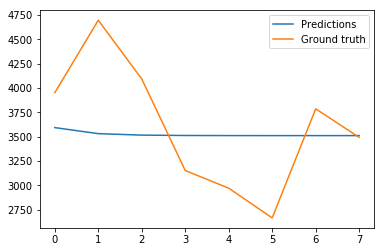

In [12]:
plt.plot(next_predictions, label="Predictions")
plt.plot(test_one_country["cases"].tolist(), label="Ground truth")
plt.legend()